In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
! pip install altair


[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "fairness-variance":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /Users/falaaharifkhan/Documents/fairness-variance


## Import dependencies

In [5]:
import altair as alt
from altair import datum

import pandas as pd
import seaborn as sns
from IPython.display import display

from configs import config
from utils.data_viz_utils import create_average_metrics_df, visualize_fairness_metrics_for_prediction_metric
from utils.custom_classes.metrics_composer import MetricsComposer

sns.set_theme(style="whitegrid")

## Create average metrics files

In [6]:
DATASET_NAME = "COMPAS_Without_Sensitive_Attributes"
#MODELS_NAMES = [model_config['model_name'] for model_config in config.MODELS_CONFIG if 'MLPClassifier' not in model_config['model_name']]
MODELS_NAMES = [model_config['model_name'] for model_config in config.MODELS_CONFIG]
MODELS_NAMES

['LogisticRegression',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'XGBClassifier',
 'KNeighborsClassifier',
 'MLPClassifier']

In [7]:
models_average_results_dct = create_average_metrics_df(DATASET_NAME, MODELS_NAMES,
                                                       results_path=os.path.join('results', 'hypothesis_space',
                                                                                 'compas_without_sensitive_attrs_metrics'))

File with average metrics for LogisticRegression is created
File with average metrics for DecisionTreeClassifier is created
File with average metrics for RandomForestClassifier is created
File with average metrics for XGBClassifier is created
File with average metrics for KNeighborsClassifier is created


## Visualize average metrics

In [8]:
SENSITIVE_ATTRIBUTES = ['sex', 'race', 'sex_race']

# Example of MetricsComposer usage
metrics_composer = MetricsComposer(SENSITIVE_ATTRIBUTES, models_average_results_dct['DecisionTreeClassifier'])
metrics_composer.compose_metrics()

,sex,race,sex_race
Equalized_Odds_TPR,-0.106167,0.248705,0.146316
Equalized_Odds_FPR,-0.088061,0.183348,0.094872
Disparate_Impact,0.879766,1.448912,1.330000
Statistical_Parity_Difference,-0.110941,0.312635,0.238195
Accuracy_Parity,0.019069,-0.008307,-0.001865
Label_Stability_Ratio,0.985852,0.968496,0.946974
IQR_Parity,-0.006781,0.009437,0.002019
Std_Parity,-0.003718,0.007724,0.002735
Std_Ratio,0.955661,1.098379,1.034903
Jitter_Parity,0.002164,0.022926,0.030554


### Overall metrics visualizations

In [9]:
def visualize_overall_metrics(models_average_results_dct, metrics_names, reversed_metrics_names=[], x_label="Prediction Metrics"):
    metrics_names = set(metrics_names + reversed_metrics_names)

    overall_metrics_df = pd.DataFrame()
    for model_name in models_average_results_dct.keys():
        model_average_results_df = models_average_results_dct[model_name].reset_index().copy(deep=True)
        model_average_results_df = model_average_results_df.loc[model_average_results_df['index'].isin(metrics_names)]
        overall_model_metrics_df = pd.DataFrame()
        overall_model_metrics_df['overall'] = model_average_results_df['overall']
        overall_model_metrics_df['metric'] = model_average_results_df['index']
        overall_model_metrics_df['model_name'] = model_name
        overall_metrics_df = pd.concat([overall_metrics_df, overall_model_metrics_df])

    overall_metrics_df.loc[overall_metrics_df['metric'].isin(reversed_metrics_names), 'overall'] = \
        1 - overall_metrics_df.loc[overall_metrics_df['metric'].isin(reversed_metrics_names), 'overall']

    # Draw a nested barplot
    height = 9 if len(metrics_names) >= 7 else 6
    g = sns.catplot(
        data=overall_metrics_df, kind="bar",
        x="overall", y="metric", hue="model_name",
        #errorbar="sd", 
        palette="bright",
        alpha=.8, height=height
    )
    g.despine(left=True)
    g.set_axis_labels("", x_label)
    g.legend.set_title("")


def overall_metric_comparison(prediction_metric_name, dataset_name, models_average_results_dct):
    comparison_df = pd.DataFrame(columns=('Dataset_Name', 'Metric_Name', 'Model_Name', 'Metric_Value'))
    for idx, model_name in enumerate(models_average_results_dct.keys()):
        model_average_results_df = models_average_results_dct[model_name]
        comparison_df.loc[idx] = [dataset_name, prediction_metric_name, model_name, model_average_results_df['overall'].loc[prediction_metric_name]]

    return comparison_df.sort_values(by=['Metric_Value'], ascending=False, axis=0)

In [10]:
def display_all_overall_metrics(dataset_name, model_names, models_average_results_dct):
    overall_metrics = list(models_average_results_dct[list(models_average_results_dct.keys())[0]].index)

    for overall_metric in overall_metrics:
        comparison_df = overall_metric_comparison(overall_metric, dataset_name, models_average_results_dct)
        print('#' * 30, f' {overall_metric} Comparison ', '#' * 30)
        display(comparison_df)

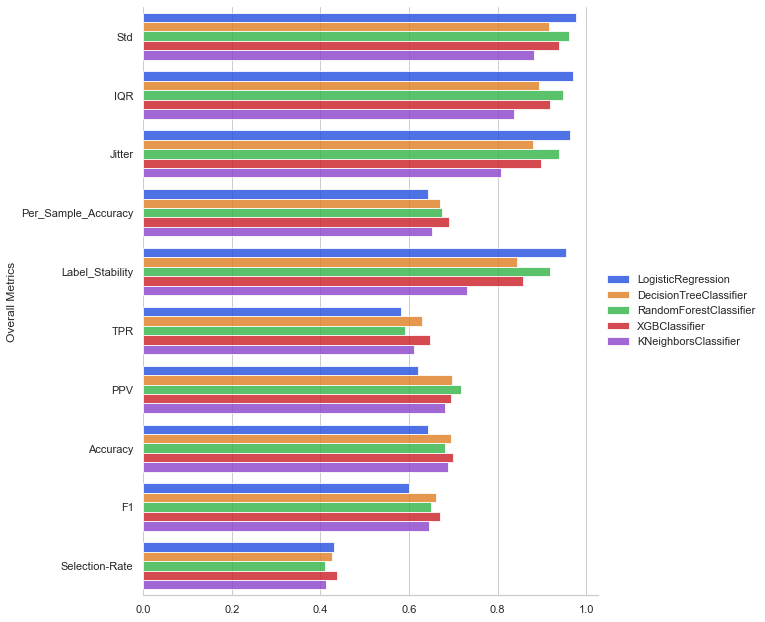

In [11]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate',
                                         'Per_Sample_Accuracy', 'Label_Stability'],
                          reversed_metrics_names=['Std', 'IQR', 'Jitter'],
                          x_label="Overall Metrics")

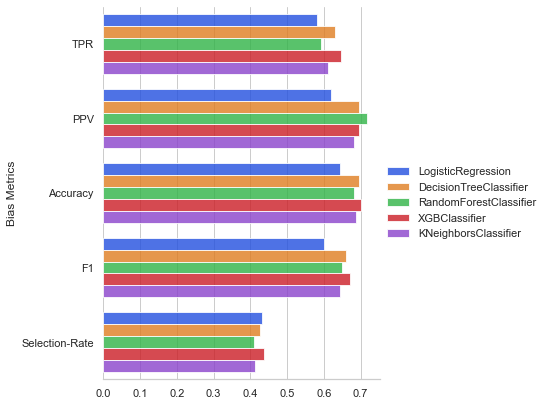

In [12]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate'],
                          x_label="Bias Metrics")

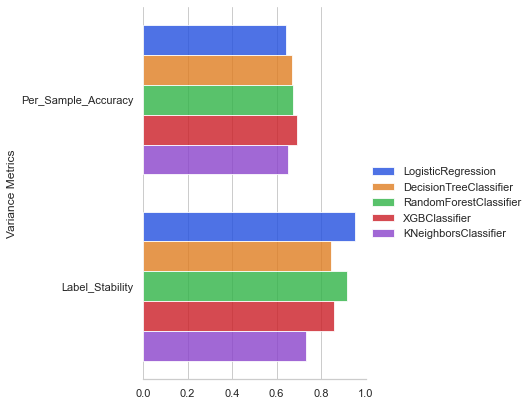

In [13]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['Per_Sample_Accuracy', 'Label_Stability'],
                          x_label="Variance Metrics")

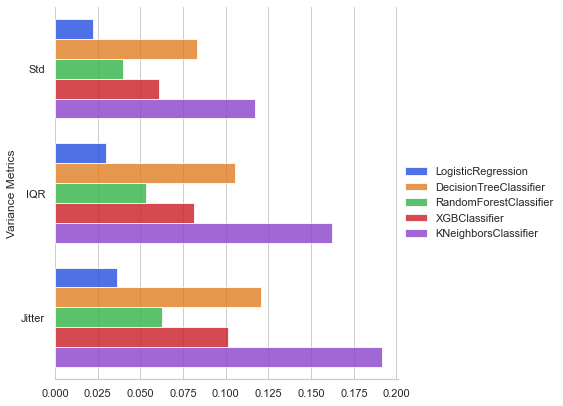

In [14]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['Std', 'IQR', 'Jitter'],
                          x_label="Variance Metrics")

In [15]:
models_average_results_df = pd.DataFrame()

for model_name in models_average_results_dct.keys():
    model_results_df = models_average_results_dct[model_name].reset_index()
    model_results_df['Model_Name'] = model_name
    model_results_df = model_results_df.rename(columns={"index": "Metric"})
    
    models_average_results_df = pd.concat([models_average_results_df, model_results_df])

models_average_results_df.head(30)

,Metric,overall,sex_race_priv,sex_race_dis,sex_priv,sex_dis,race_priv,race_dis,Model_Name
0,General_Ensemble_Accuracy,0.642992,0.654867,0.657658,0.647608,0.623116,0.639344,0.645469,LogisticRegression
1,Mean,0.525411,0.588531,0.530116,0.516933,0.561921,0.591315,0.480671,LogisticRegression
2,Std,0.022600,0.021210,0.020623,0.023063,0.020606,0.021081,0.023631,LogisticRegression
3,IQR,0.030190,0.028079,0.027884,0.030828,0.027441,0.027832,0.031790,LogisticRegression
4,Entropy,0.000000,0.000000,0.000000,0.000000,0.059222,0.000000,0.071021,LogisticRegression
5,Jitter,0.036394,0.028761,0.035182,0.037083,0.033427,0.029267,0.041232,LogisticRegression
6,Per_Sample_Accuracy,0.642609,0.652758,0.661306,0.647071,0.623392,0.636850,0.646518,LogisticRegression
7,Label_Stability,0.954290,0.963982,0.957027,0.953326,0.958442,0.963208,0.948235,LogisticRegression
8,TPR,0.581109,0.432836,0.577778,0.601918,0.457143,0.402516,0.667683,LogisticRegression
9,TNR,0.695958,0.800000,0.712121,0.690909,0.713178,0.779851,0.621262,LogisticRegression


In [16]:
df_for_models_bias_metrics_chart = models_average_results_df.melt(id_vars=["Metric", "Model_Name", "overall"],
                                                                  var_name="Subgroup",
                                                                  value_name="Value")
df_for_models_bias_metrics_chart[df_for_models_bias_metrics_chart["Model_Name"] == "LogisticRegression"]

,Metric,Model_Name,overall,Subgroup,Value
0,General_Ensemble_Accuracy,LogisticRegression,0.642992,sex_race_priv,0.654867
1,Mean,LogisticRegression,0.525411,sex_race_priv,0.588531
2,Std,LogisticRegression,0.022600,sex_race_priv,0.021210
3,IQR,LogisticRegression,0.030190,sex_race_priv,0.028079
4,Entropy,LogisticRegression,0.000000,sex_race_priv,0.000000
...,...,...,...,...,...
437,FPR,LogisticRegression,0.304042,race_dis,0.378738
438,Accuracy,LogisticRegression,0.642992,race_dis,0.645469
439,F1,LogisticRegression,0.600212,race_dis,0.662632
440,Selection-Rate,LogisticRegression,0.431818,race_dis,0.529412


In [17]:
models_composed_metrics_df = pd.DataFrame()
for model_name in models_average_results_dct.keys():
    metrics_composer = MetricsComposer(SENSITIVE_ATTRIBUTES, models_average_results_dct[model_name])
    model_composed_metrics_df = metrics_composer.compose_metrics().reset_index()
    model_composed_metrics_df['Model_Name'] = model_name
    model_composed_metrics_df = model_composed_metrics_df.rename(columns={"index": "Metric"})
    
    models_composed_metrics_df = pd.concat([models_composed_metrics_df, model_composed_metrics_df])

models_composed_metrics_df.head(20)

,Metric,sex,race,sex_race,Model_Name
0,Equalized_Odds_TPR,-0.144776,0.265167,0.144942,LogisticRegression
1,Equalized_Odds_FPR,-0.022269,0.158588,0.087879,LogisticRegression
2,Disparate_Impact,1.062126,1.312388,1.353535,LogisticRegression
3,Statistical_Parity_Difference,0.057657,0.241659,0.261194,LogisticRegression
4,Accuracy_Parity,-0.024492,0.006125,0.002790,LogisticRegression
5,Label_Stability_Ratio,1.005367,0.984455,0.992785,LogisticRegression
6,IQR_Parity,-0.003387,0.003958,-0.000194,LogisticRegression
7,Std_Parity,-0.002457,0.002550,-0.000587,LogisticRegression
8,Std_Ratio,0.893456,1.120979,0.972321,LogisticRegression
9,Jitter_Parity,-0.003656,0.011966,0.006421,LogisticRegression


In [18]:
df_for_model_metrics_chart = models_composed_metrics_df.melt(id_vars=["Metric", "Model_Name"],
                                                                   var_name="Subgroup",
                                                                   value_name="Value")
#df_for_model_metrics_chart[df_for_model_metrics_chart["Model_Name"] == "LogisticRegression"]
df_for_model_metrics_chart

,Metric,Model_Name,Subgroup,Value
0,Equalized_Odds_TPR,LogisticRegression,sex,-0.144776
1,Equalized_Odds_FPR,LogisticRegression,sex,-0.022269
2,Disparate_Impact,LogisticRegression,sex,1.062126
3,Statistical_Parity_Difference,LogisticRegression,sex,0.057657
4,Accuracy_Parity,LogisticRegression,sex,-0.024492
...,...,...,...,...
145,Label_Stability_Ratio,KNeighborsClassifier,sex_race,0.890928
146,IQR_Parity,KNeighborsClassifier,sex_race,0.010507
147,Std_Parity,KNeighborsClassifier,sex_race,0.005407
148,Std_Ratio,KNeighborsClassifier,sex_race,1.047441


In [19]:
def create_models_metrics_bar_chart(df, metrics_lst, default_plot_metric, metrics_group_name):
    df_for_model_metrics_chart = df.loc[df['Metric'].isin(metrics_lst)]
    
    radio_select = alt.selection_single(fields=['Metric'], init={'Metric': default_plot_metric}, empty="none")
    color_condition = alt.condition(radio_select,
                          alt.Color('Metric:N', legend=None, scale=alt.Scale(scheme="tableau20")),
                          alt.value('lightgray'))


    models_metrics_chart = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_bar()
            .transform_filter(radio_select)
            .encode(
                x='Value:Q',
                y=alt.Y('Model_Name:N', axis=None),
                color=alt.Color(
                    'Model_Name:N',
                    scale=alt.Scale(scheme="tableau20")
                ),
                row='Subgroup:N',
            )
    )


    select_metric_legend = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_circle(size=200)
            .encode(
                y=alt.Y("Metric:N", axis=alt.Axis(title=f"Select {metrics_group_name} Metric", titleFontSize=15)),
                color=color_condition,
            )
            .add_selection(radio_select)
    )


    color_legend = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_circle(size=200)
            .encode(
                y=alt.Y("Model_Name:N", axis=alt.Axis(title="Model Name", titleFontSize=15)),
                color=alt.Color("Model_Name:N", scale=alt.Scale(scheme="tableau20")),
            )
    )
    
    return models_metrics_chart, select_metric_legend, color_legend

In [20]:
bias_metrics_lst = [
    'Accuracy_Parity',
    'Equalized_Odds_TPR',
    'Equalized_Odds_FPR',
    'Disparate_Impact',
    'Statistical_Parity_Difference',
]
models_bias_metrics_chart, select_bias_metric_legend, bias_color_legend = \
                create_models_metrics_bar_chart(df_for_model_metrics_chart, bias_metrics_lst, 
                                                default_plot_metric=bias_metrics_lst[0],
                                                metrics_group_name="Bias")

In [21]:
variance_metrics_lst = [
    'IQR_Parity',
    'Label_Stability_Ratio',
    'Std_Parity',
    'Std_Ratio',
    'Jitter_Parity',
]
models_variance_metrics_chart, select_variance_metric_legend, variance_color_legend = \
                create_models_metrics_bar_chart(df_for_model_metrics_chart, variance_metrics_lst,
                                                default_plot_metric=variance_metrics_lst[0],
                                                metrics_group_name="Variance")

In [22]:
(
    alt.hconcat(
        alt.vconcat(
            select_bias_metric_legend.properties(height=200, width=50),
            select_variance_metric_legend.properties(height=200, width=50),
            bias_color_legend.properties(height=200, width=50),
        ),
        models_bias_metrics_chart.properties(height=200, width=300, title="Bias Metric Plot"),
        models_variance_metrics_chart.properties(height=200, width=300, title="Variance Metric Plot"),
    )
)

alt.HConcatChart(...)

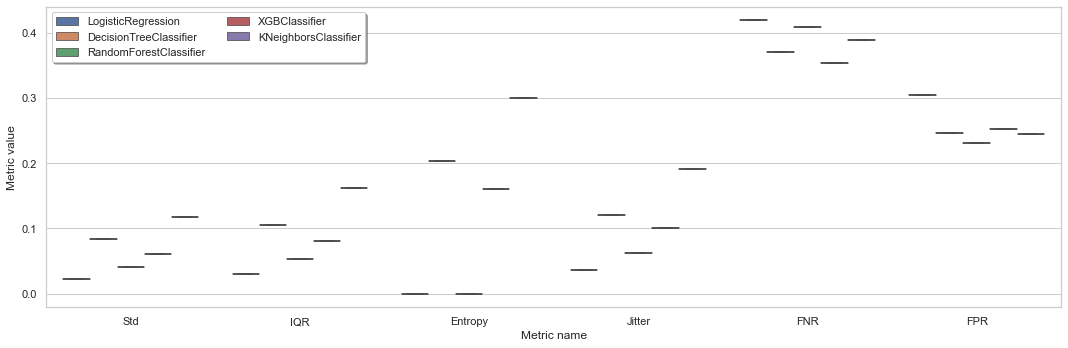

In [23]:
to_plot = models_average_results_df[models_average_results_df['Metric'].isin(['Std', 'IQR', 'Entropy', 'Jitter', 'FNR','FPR'])]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))


sns.boxplot(
            x = to_plot['Metric'],
            y = to_plot['overall'],
            hue= to_plot['Model_Name'],
            #order=['Accuracy']
            #order=['Accuracy','TNR','TPR','FNR','FPR','Selection-Rate']
            )

plt.legend(loc='upper left',
          ncol=2, fancybox=True, shadow=True)
plt.xlabel("Metric name")
plt.ylabel("Metric value")
#plt.ylim(0,1)
#plt.title("Peformance on overall test set: "+experiment)

plt.tight_layout()

#plt.savefig(filename+'_overall.png', bbox_inches='tight')

In [24]:
sorted_res = df_for_model_metrics_chart.sort_values(by=['Value'])

In [25]:
set(sorted_res.Metric)

{'Accuracy_Parity',
 'Disparate_Impact',
 'Equalized_Odds_FPR',
 'Equalized_Odds_TPR',
 'IQR_Parity',
 'Jitter_Parity',
 'Label_Stability_Ratio',
 'Statistical_Parity_Difference',
 'Std_Parity',
 'Std_Ratio'}

In [26]:
def color_df(val):
    if val is 'RandomForestClassifier':
        color = 'pink' 
    if val is 'LogisticRegression':
        color = 'yellow'
    if val is 'DecisionTreeClassifier':
        color = 'cyan'
    if val is 'XGBClassifier':
        color = 'green'
    if val is 'KNeighborsClassifier':
        color = 'orange'
    if val is 'MLPClassifier':
        color = 'purple'
    return 'background-color: %s' % color

In [27]:
results = {}

for metric in ['Disparate_Impact','Label_Stability_Ratio']:
    for subgroup in ['sex','race','sex_race']:
        key_name = metric+'_'+subgroup
        results[key_name] = sorted_res[(sorted_res.Metric == metric) & (sorted_res.Subgroup == subgroup)]['Model_Name'].values
        
#pd.DataFrame(results).T
pd.DataFrame(results).T.style.applymap(color_df)

,0,1,2,3,4
Disparate_Impact_sex,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,LogisticRegression,XGBClassifier
Disparate_Impact_race,RandomForestClassifier,XGBClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier
Disparate_Impact_sex_race,RandomForestClassifier,DecisionTreeClassifier,LogisticRegression,XGBClassifier,KNeighborsClassifier
Label_Stability_Ratio_sex,XGBClassifier,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression
Label_Stability_Ratio_race,KNeighborsClassifier,DecisionTreeClassifier,LogisticRegression,RandomForestClassifier,XGBClassifier
Label_Stability_Ratio_sex_race,KNeighborsClassifier,XGBClassifier,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression


In [28]:
results = {}

for metric in ['Accuracy_Parity','Equalized_Odds_FPR','Statistical_Parity_Difference','IQR_Parity','Jitter_Parity','Std_Parity']:
    for subgroup in ['sex','race','sex_race']:
        key_name = metric+'_'+subgroup
        results[key_name] = sorted_res[(sorted_res.Metric == metric) & (sorted_res.Subgroup == subgroup)]['Model_Name'].values
        
pd.DataFrame(results).T.style.applymap(color_df)

,0,1,2,3,4
Accuracy_Parity_sex,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier,XGBClassifier
Accuracy_Parity_race,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,LogisticRegression,XGBClassifier
Accuracy_Parity_sex_race,KNeighborsClassifier,DecisionTreeClassifier,LogisticRegression,RandomForestClassifier,XGBClassifier
Equalized_Odds_FPR_sex,DecisionTreeClassifier,RandomForestClassifier,XGBClassifier,KNeighborsClassifier,LogisticRegression
Equalized_Odds_FPR_race,RandomForestClassifier,XGBClassifier,KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier
Equalized_Odds_FPR_sex_race,RandomForestClassifier,XGBClassifier,KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier
Statistical_Parity_Difference_sex,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,LogisticRegression,XGBClassifier
Statistical_Parity_Difference_race,RandomForestClassifier,XGBClassifier,KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier
Statistical_Parity_Difference_sex_race,RandomForestClassifier,DecisionTreeClassifier,LogisticRegression,XGBClassifier,KNeighborsClassifier
IQR_Parity_sex,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,XGBClassifier
